In [1]:
import torch,sys, os
sys.path.append('../')
import numpy as np
import torch.nn as nn
from torch.optim import Adam,SGD,lr_scheduler
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from utils import DiceLoss, SquarePad,SquarePad255,AddGaussianNoise
from torch.utils.data import Dataset, DataLoader,ConcatDataset,Subset,ConcatDataset
from UNET_LIB.InceptionUnet import InceptionUNet
from LAIPAS_Images.LAIPAS_DATA import LAIPAS_Dataset
from torch.utils.tensorboard import SummaryWriter
num_classes=4

# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=False)
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=False)
model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

# teacher_net = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=False)
teacher_net = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=False)
teacher_net.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
teacher_net.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
    
with torch.no_grad():
    for ema_para,para in zip(teacher_net.parameters(),model.parameters()):
        ema_para.data = para.data

model = nn.DataParallel(model).cuda()
teacher_net = nn.DataParallel(teacher_net).cuda()

img_preprocess = transforms.Compose([    
#     SquarePad(),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(0,1),
#     AddGaussianNoise(0,0.1)
])

val_preprocess = transforms.Compose([    
#     SquarePad(),
    transforms.ToTensor(),
    transforms.Normalize(0,1),
])


msk_preprocess = transforms.Compose([])


variant = '_pat_bal'
optim_spec = 'SGDL'
weighted = ''
ignore=False
loss_spec = 'CE_fixed'
assert loss_spec in ['Dice', 'CE','CE_fixed', 'CE_dynamic'] 
assert weighted in ['_weighted','']
# model_name = f'DLab50_LAIPAS_{variant}_o{optim_spec}{weighted}_no255_MT_wCTL'
model_name = f'DLab101_LAIPAS_{variant}_o{optim_spec}{weighted}_no255_MT_wCTL_21kIter_poly'
train_size = 384

#PAS data, labeled, sample 4 from this set
train_DATA = LAIPAS_Dataset('./LAIPAS_Images/', 'train'+variant, 
                                img_preprocess, msk_preprocess,crop_size=train_size,ignore=ignore)
#No_PAS data, labeled, sample 4 from this set
ctl_DATA = Subset(LAIPAS_Dataset('./LAIPAS_Images/', 'ctl', 
                                img_preprocess, msk_preprocess,crop_size=train_size,ignore=ignore),range(0,73))
#sample 8 from this set
unlabeled_DATA_train =  LAIPAS_Dataset('./LAIPAS_Images/', 'unlabeled' + variant, 
                                img_preprocess, msk_preprocess,crop_size=train_size, ignore=ignore) 


val_tune = Subset(LAIPAS_Dataset('./LAIPAS_Images/', 'val', img_preprocess, msk_preprocess,
                                  crop_size=train_size,ignore=ignore),range(0,28))

val_test = Subset(LAIPAS_Dataset('./LAIPAS_Images/', 'val', val_preprocess, msk_preprocess,
                          rot = False, resize=False,crop_size = 1024,ignore=False), range(28,72))

ctl_test = Subset(LAIPAS_Dataset('./LAIPAS_Images/', 'ctl', val_preprocess, msk_preprocess,
                          rot = False, resize=False,crop_size = 1024,ignore=False), range(73,98))

test = ConcatDataset([val_test,ctl_test])

#sample 4
loader_l_pa = DataLoader(train_DATA, batch_size=4, shuffle=True, drop_last=True, num_workers=8,pin_memory=True)
#sample 4
loader_l_npa= DataLoader(ctl_DATA, batch_size=4, shuffle=True, drop_last=True, num_workers=8,pin_memory=True)
iter_l_npa = iter(loader_l_npa)
# #sample 8
loader_u_tr = DataLoader(unlabeled_DATA_train, batch_size=8, shuffle=True, drop_last=True, num_workers=8,pin_memory=True)
iter_u_tr = iter(loader_u_tr)


tune_loader = DataLoader(val_tune, batch_size=8, shuffle=False, drop_last=False, num_workers=8,pin_memory=True)
test_loader = DataLoader(test, batch_size=8, shuffle=False, drop_last=False, num_workers=8,pin_memory=True)

Using cache found in /home/yz696/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/yz696/.cache/torch/hub/pytorch_vision_v0.10.0


In [2]:

def get_IOU(class_id):
    I = torch.cat([intersection_frames[_+class_id] for _ in range(0,len(intersection_frames),num_classes)])
    U = torch.cat([union_frames[_+class_id] for _ in range(0,len(intersection_frames),num_classes)])
    return (I/U).round(decimals = 4)

In [3]:
from glob import glob
model_names = glob('final_model/*.pth')+glob('LAIPAS_Images/model_checkpoints/*.pth')


In [5]:
for model_name in model_names:

    try:
        checkpoint = torch.load(model_name)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(model_name)
    except:
        continue
    intersection_frames= [] 
    union_frames= [] 
    model.eval()
    num_classes = 4
    with torch.no_grad():
        for idx,(X,y) in enumerate(test_loader):
    
            y = y.cuda().contiguous()
            if 'DLab' in model_name:
                yhat = model(X.contiguous().cuda())['out']
            else:
                yhat = model(X.contiguous().cuda())
    
            ypred = torch.argmax(yhat, dim=1)
    
            for j in range(num_classes):
                y_binarized = torch.where( y==j,1,0)
                ypred_binarized=torch.where(ypred == j,1,0)
    
                intersect_ = (y_binarized*ypred_binarized).sum([1,2])+1e-4
                union_ = (y_binarized+ypred_binarized).clip(max=1).sum([1,2])+1e-4
    
                intersection_frames.append(intersect_.cpu())
                union_frames.append(union_.cpu())

    
    for i in range(num_classes):
        temp = get_IOU(i)
        print(temp.mean())
    

final_model/DLab101_LAIPAS__pat_bal_oSGDL_no255_MT_wCTL_15kIter.pth
tensor(0.7456)
tensor(0.7460)
tensor(0.5878)
tensor(0.3247)
final_model/DLab101_LAIPAS__pat_bal_oSGDL_no255_MT_wCTL_21kIter_poly.pth
tensor(0.7460)
tensor(0.7444)
tensor(0.6386)
tensor(0.3487)
final_model/DLab101_LAIPAS__pat_bal_oSGDL_no255_MT_wCTL_15kIter_runningmax.pth
tensor(0.7453)
tensor(0.7454)
tensor(0.5865)
tensor(0.3221)
final_model/DLab101_LAIPAS__pat_bal_oSGDL_no255_MT_wCTL_21kIter_poly_runningmax.pth
tensor(0.7452)
tensor(0.7388)
tensor(0.6025)
tensor(0.3409)
final_model/DLab101_LAIPAS__pat_bal_oSGDL_no255_MT_wCTL_21kIter.pth
tensor(0.7483)
tensor(0.7467)
tensor(0.5545)
tensor(0.3739)
final_model/DLab101_LAIPAS__pat_bal_oSGDL_no255_MT_wCTL_18kIter_runningmax.pth
tensor(0.7453)
tensor(0.7081)
tensor(0.4993)
tensor(0.3424)
LAIPAS_Images/model_checkpoints/DLab_LAIPAS__pat_bal_oSGD_MT.pth
tensor(0.7225)
tensor(0.6951)
tensor(0.3903)
tensor(0.3558)
LAIPAS_Images/model_checkpoints/DLab_Size37_LAIPAS__pat_bal_oSGD

In [6]:
weight_name = 'LAIPAS_Images/model_checkpoints/DLab101_LAIPAS__pat_bal_oSGDL_no255_MT_wCTL_140_completed.pth'
checkpoint = torch.load(weight_name)
fin_epoch = checkpoint['fin_epoch']
min_loss = checkpoint['min_loss']
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
pred = []
orig = []
img_ = []
model.eval()
with torch.no_grad():
    class_intersect = np.zeros((num_classes,),dtype='float')
    class_union= np.zeros((num_classes,),dtype='float')
    for idx,(X,y) in enumerate(test_loader):
        y = y.cuda().contiguous()
        orig.append(y)
        img_.append(X)
        if 'DLab' not in model_name:
            yhat = model(X.contiguous().cuda())
        else:
            yhat = model(X.contiguous().cuda())['out']
        yhat_lab = torch.argmax(yhat, dim=1)
        for j in range(num_classes):

            y_bi = y == j
            yhat_bi = yhat_lab == j
            I = ((y_bi * yhat_bi).sum()).item()
            U = (y_bi.sum() + yhat_bi.sum() - I).item()
            assert I <= U
            class_intersect[j] += I
            class_union[j] += U
            
        pred.append(yhat_lab)
    yhat_lab = torch.cat(pred)
    y = torch.cat(orig)
    X = torch.cat(img_)
        

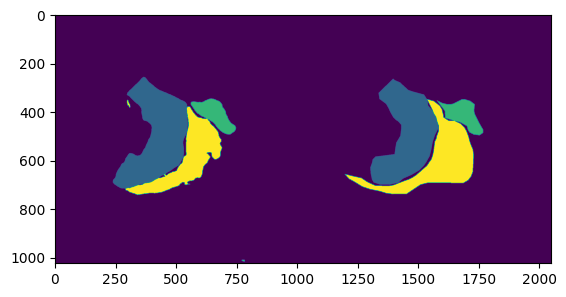

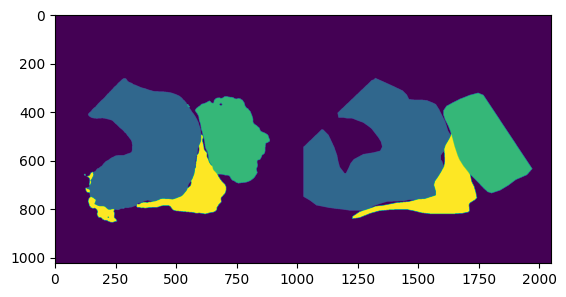

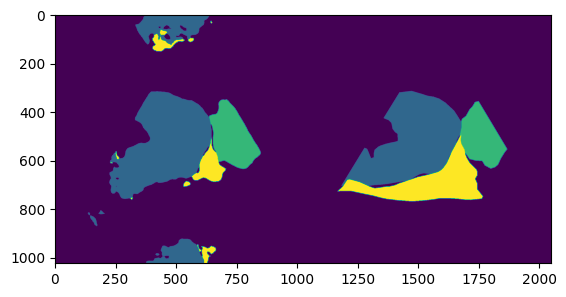

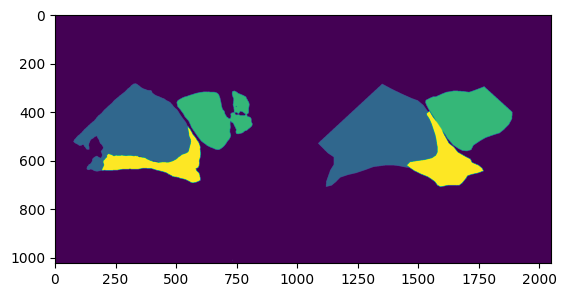

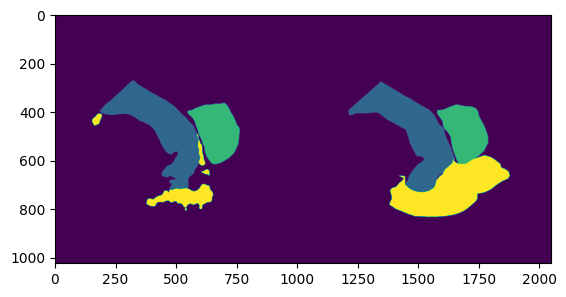

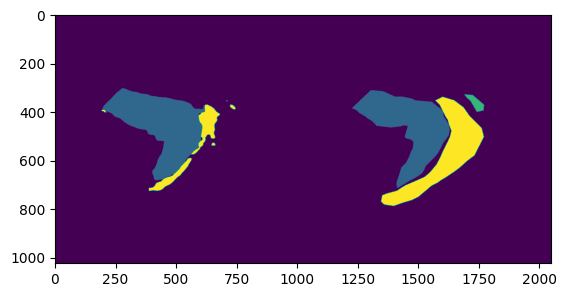

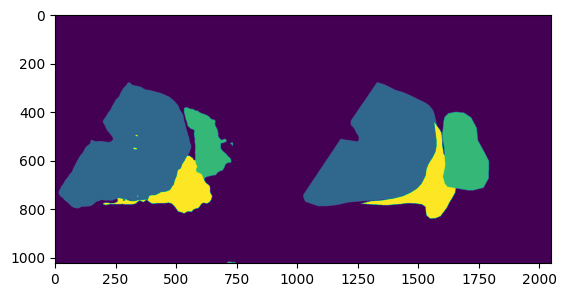

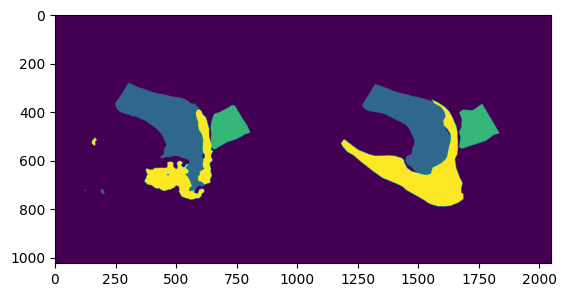

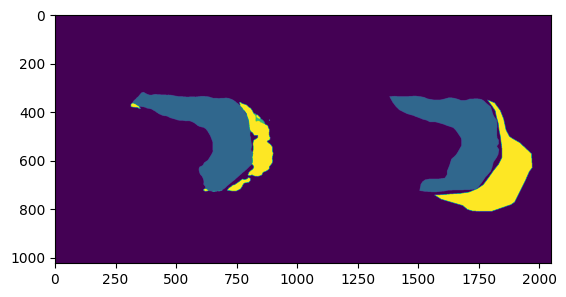

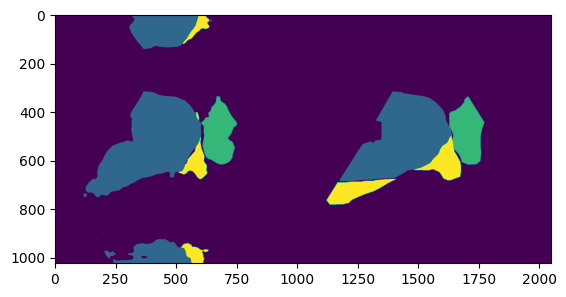

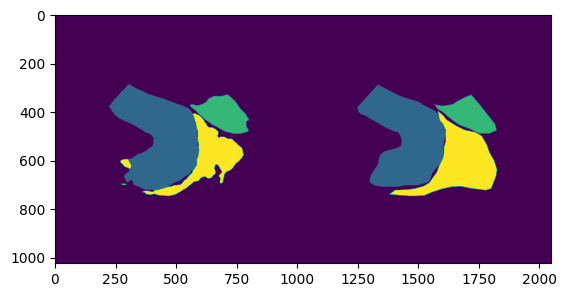

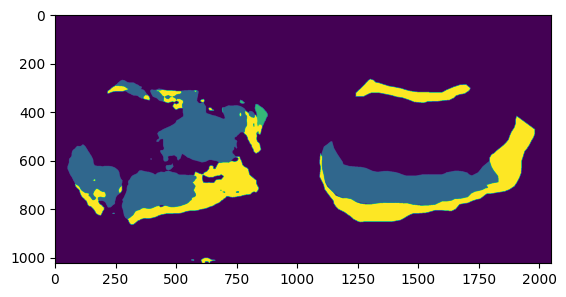

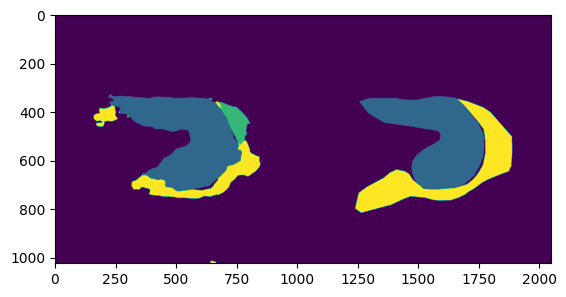

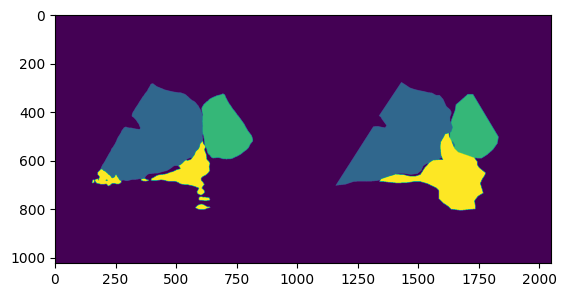

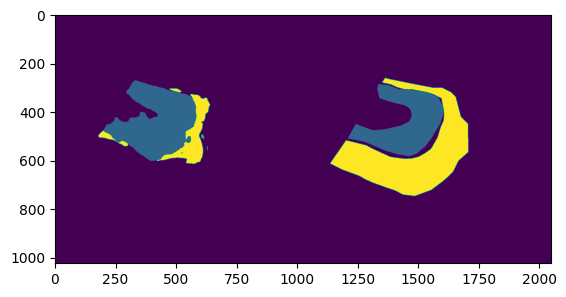

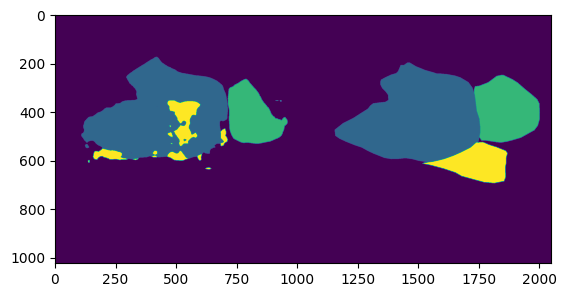

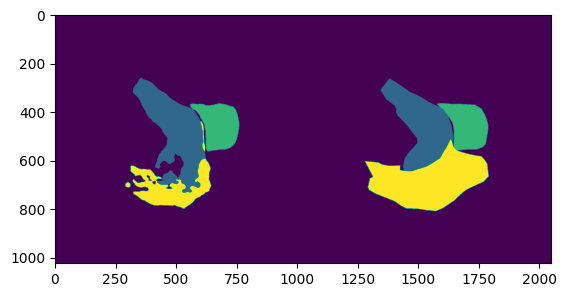

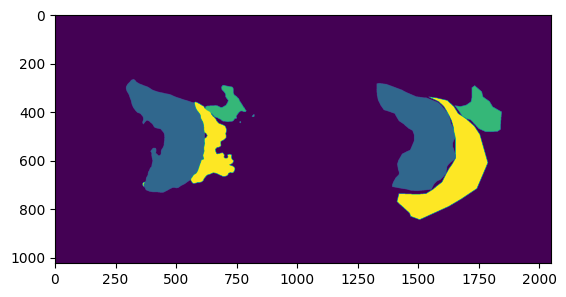

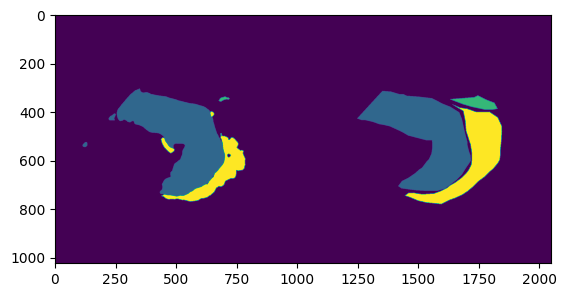

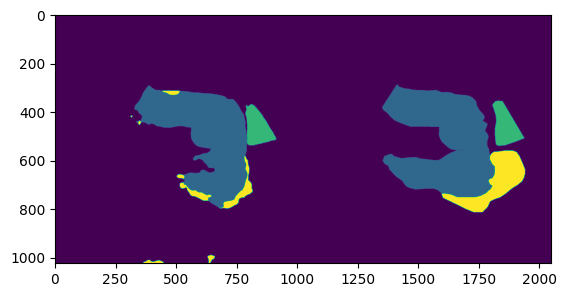

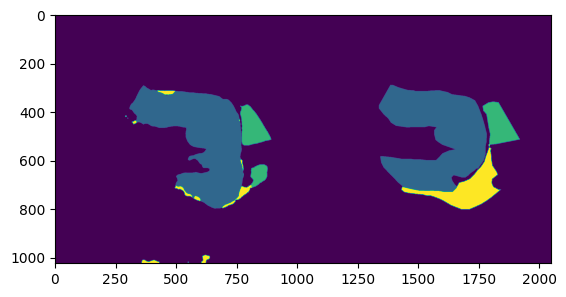

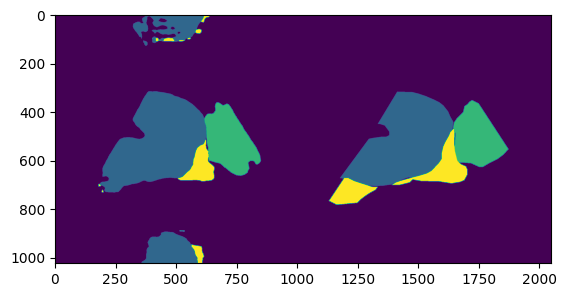

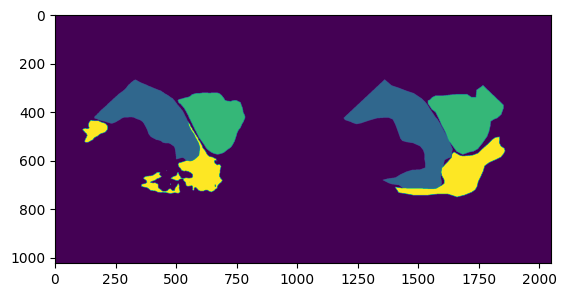

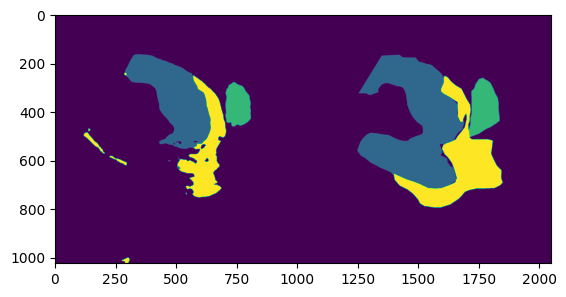

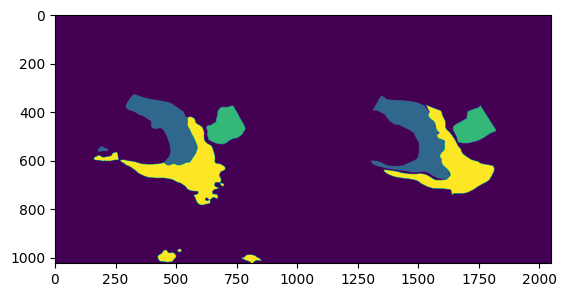

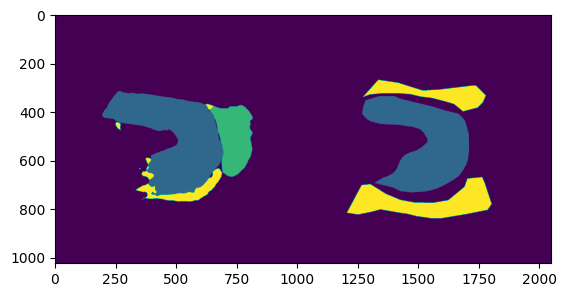

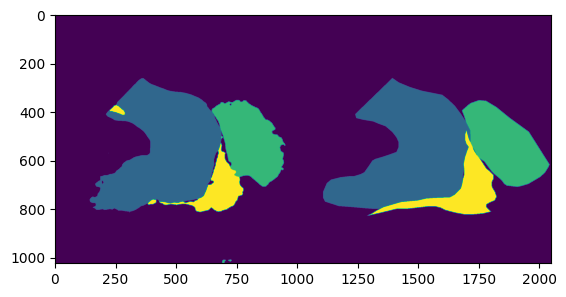

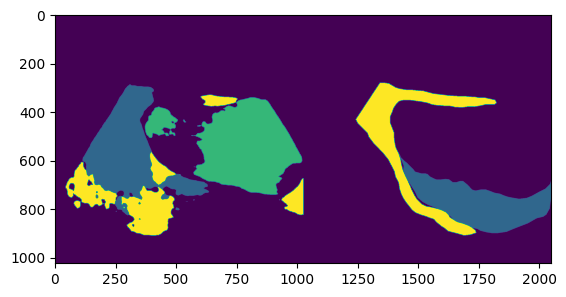

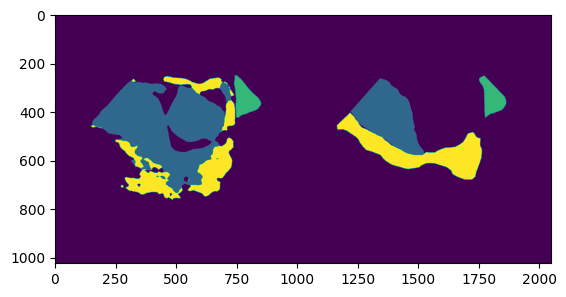

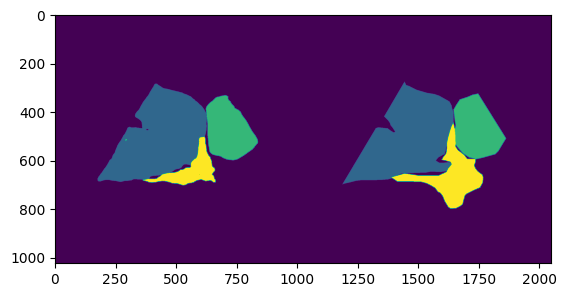

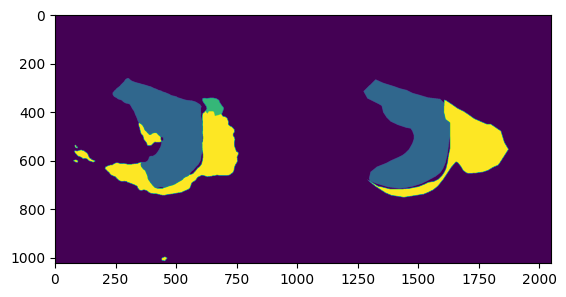

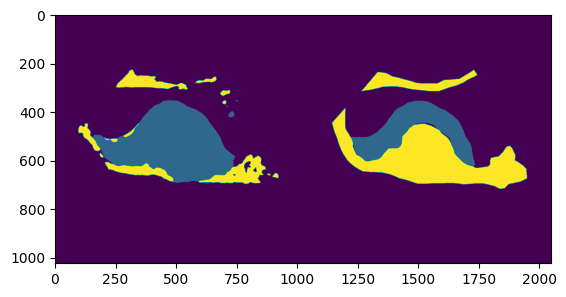

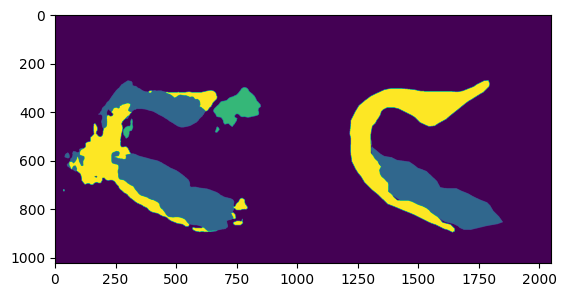

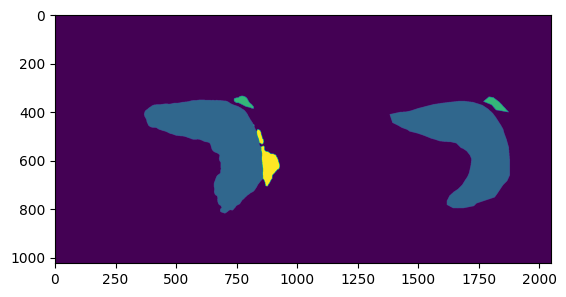

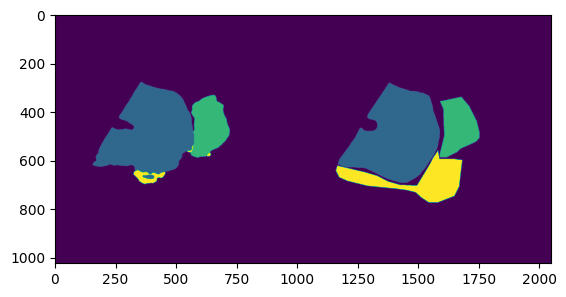

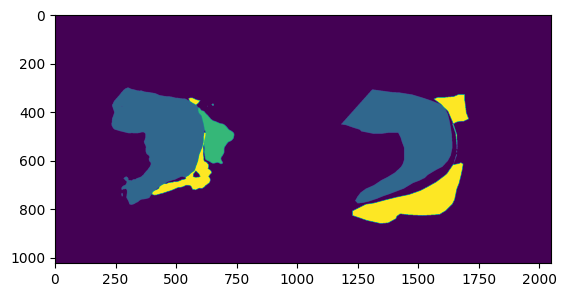

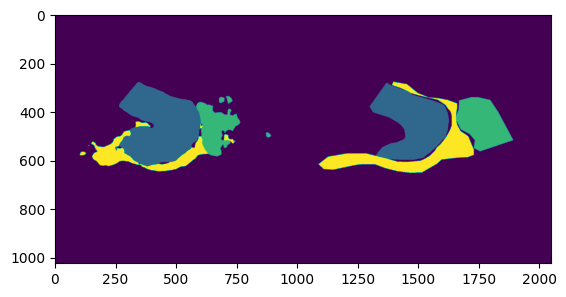

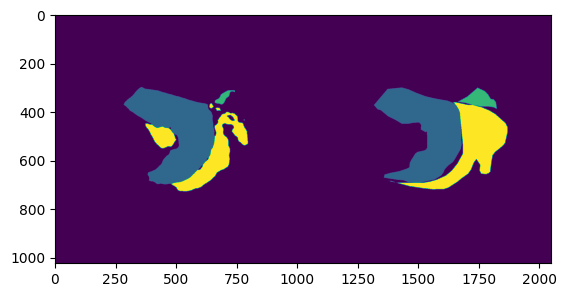

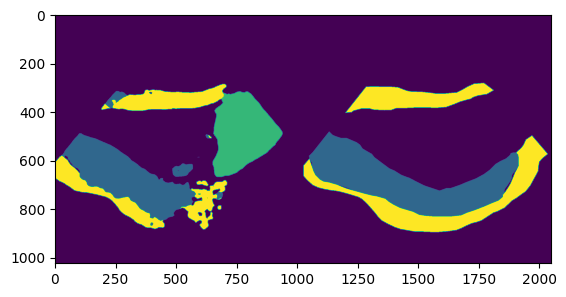

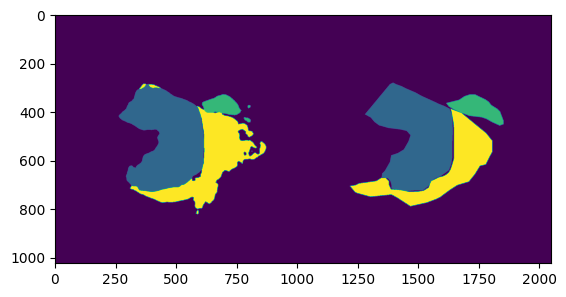

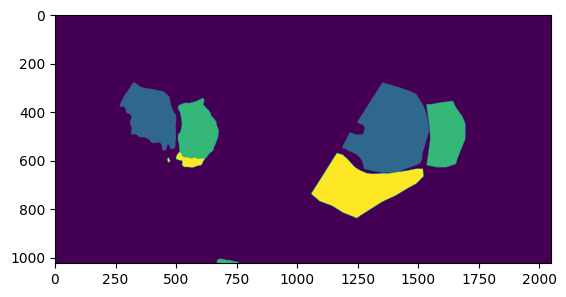

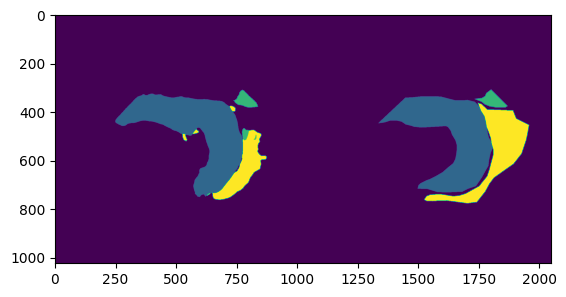

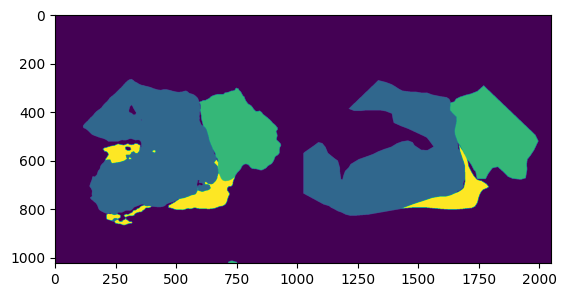

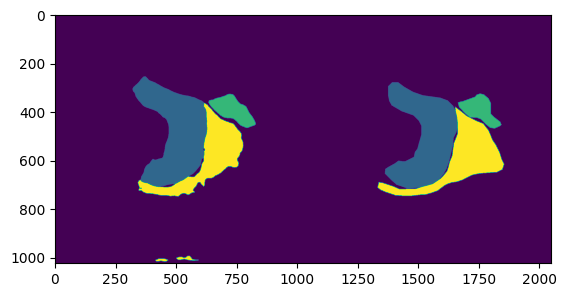

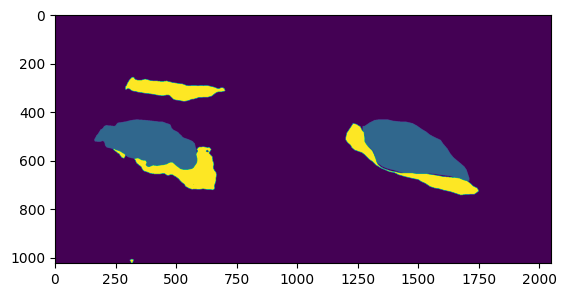

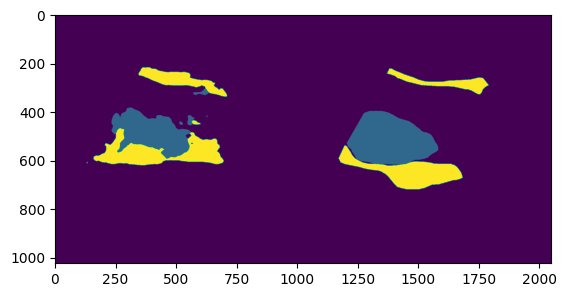

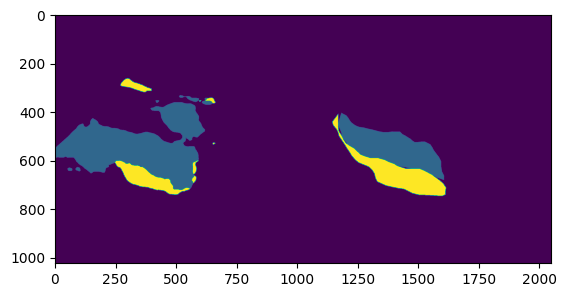

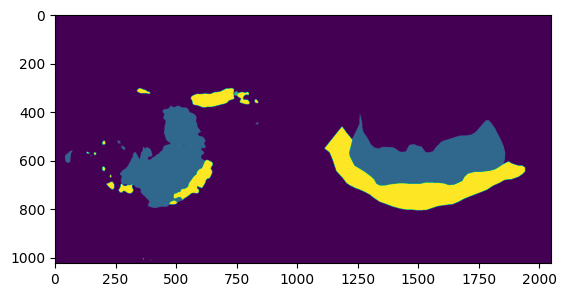

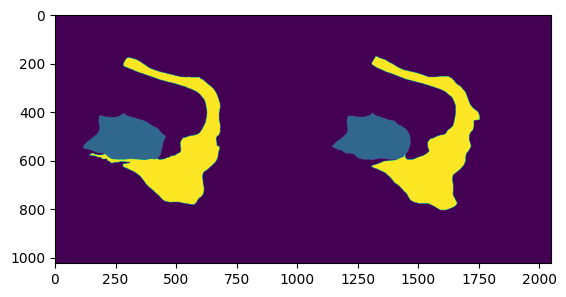

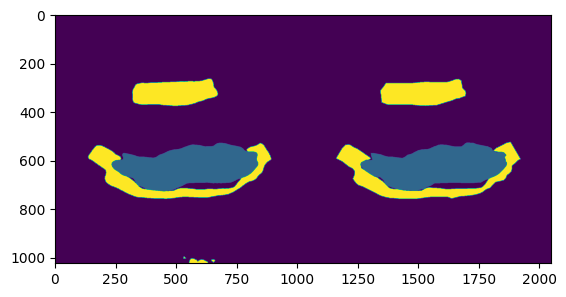

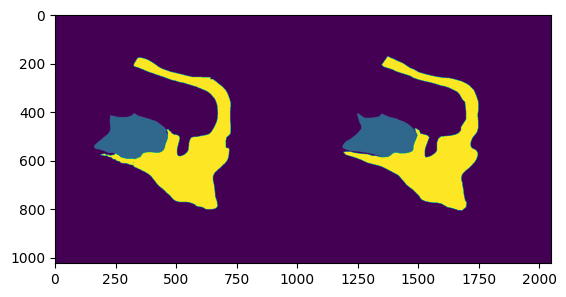

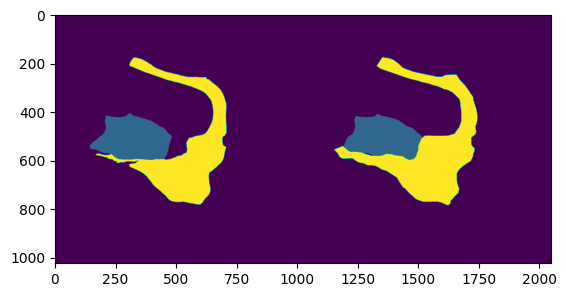

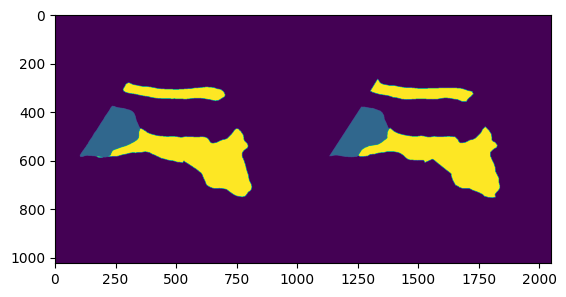

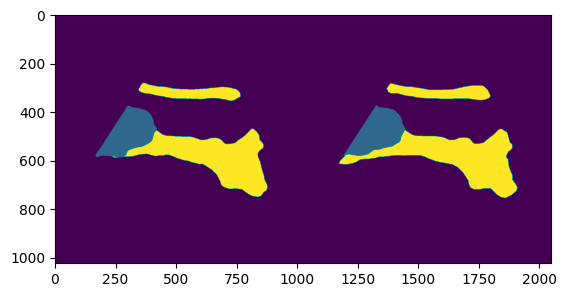

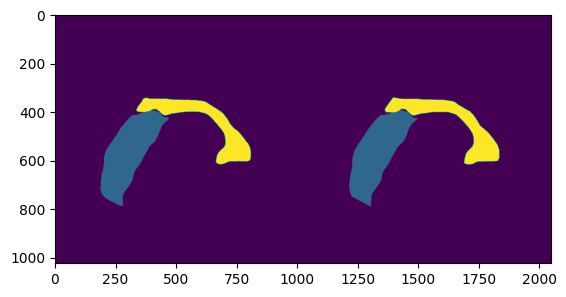

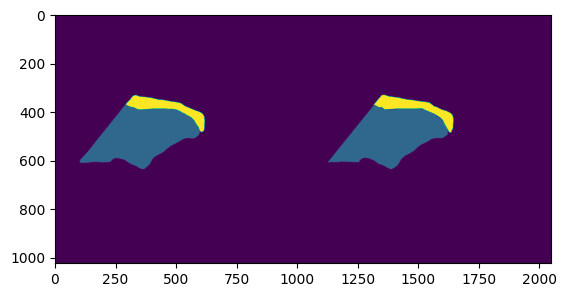

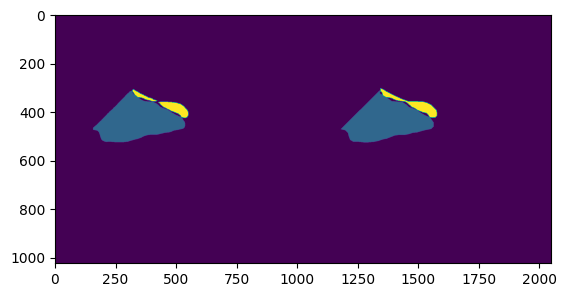

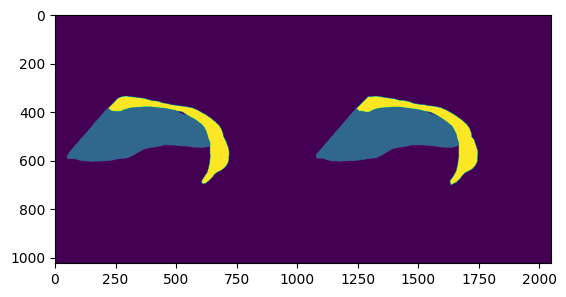

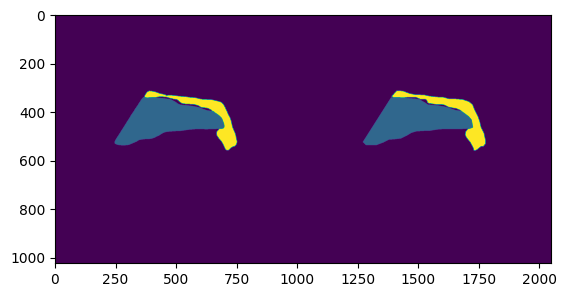

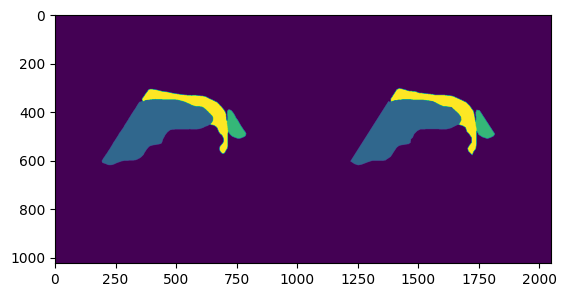

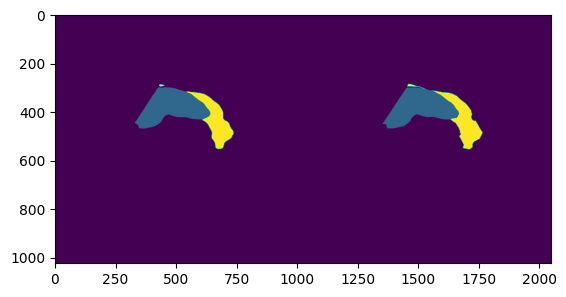

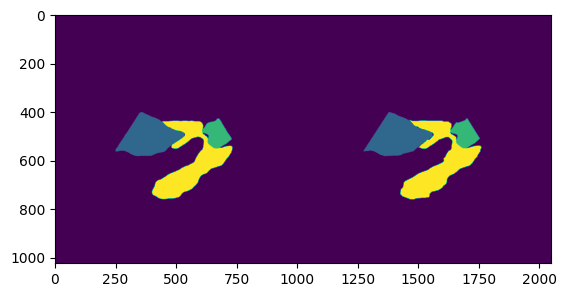

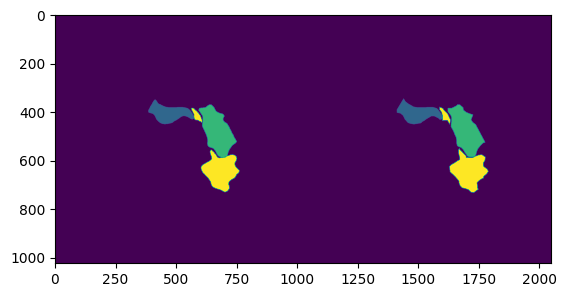

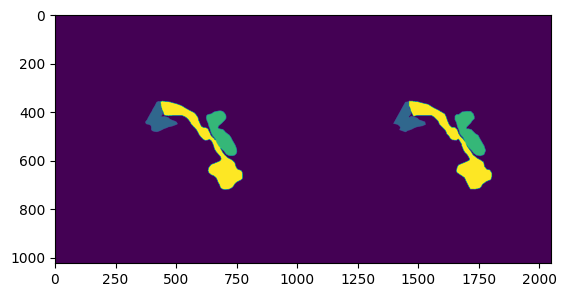

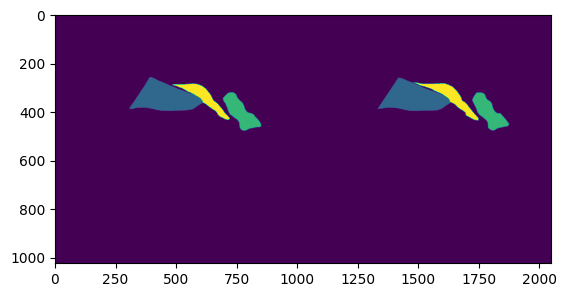

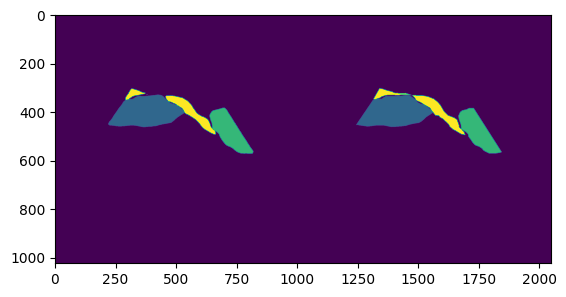

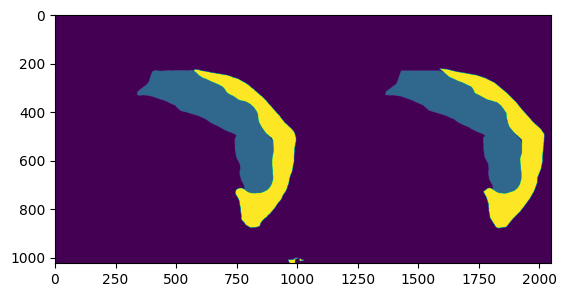

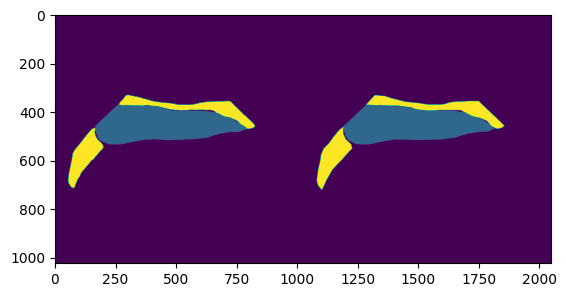

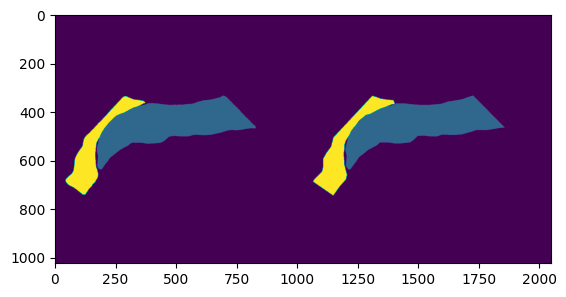

In [8]:
for _ylab,_y in zip(yhat_lab.cpu(),y.cpu()):
    _y[_y==255]=0
    plt.imshow(torch.cat([_ylab,_y],axis=1))
    plt.show()